# EoR Signal Separation with a CDAE

---

### Weitian LI

https://github.com/liweitianux/cdae-eor

**Credits:**
* https://ramhiser.com/post/2018-05-14-autoencoders-with-keras/
* https://blog.keras.io/building-autoencoders-in-keras.html

---

## Introduction

The **frequency-dependent beam effects** of interferometers can cause
rapid fluctuations along the frequency dimension, which destroy the
smoothness of the foreground spectra and prevent traditional foreground
removal methods from uncovering the EoR signal.

Given the difficulty in crafting practicable models to overcome the
complicated beam effects, methods that can learn tailored models from
the data seem more feasible and appealing.

**Convolutional denoising autoencoder** (CDAE) combines the strengths of
both denoising autoencoder and convolutional neural network and hence
is very powerful to learn robust and sophiscated features from the data.
The CDAE is well suited to learn the subtle features of the faint EoR
signal and separate it from the strong foreground emission, even in the
presence of serious beam effects.

---

## 1. Import packages and basic settings

In [1]:
import os
from os import path
from datetime import datetime
import time

import numpy as np
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy import constants as ac

from scipy import signal
from scipy import fftpack

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
mpl.style.use("ggplot")
for k, v in [("font.family",       "Inconsolata"),
             ("font.size",         14.0),
             ("pdf.fonttype",      42),  # Type 42 (a.k.a. TrueType)
             ("figure.figsize",    [8, 6]),
             ("image.cmap",        "jet"),
             ("xtick.labelsize",   "large"),
             ("xtick.major.size",  7.0),
             ("xtick.major.width", 2.0),
             ("xtick.minor.size",  4.0),
             ("xtick.minor.width", 1.5),
             ("ytick.labelsize",   "large"),
             ("ytick.major.size",  7.0),
             ("ytick.major.width", 2.0),
             ("ytick.minor.size",  4.0),
             ("ytick.minor.width", 1.5)]:
    mpl.rcParams[k] = v

In [4]:
import tensorflow as tf

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv1D
from keras.layers import MaxPool1D, UpSampling1D
from keras.optimizers import Adam

keras.__version__, tf.__version__

Using TensorFlow backend.


('2.2.4', '1.12.0')

In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)

---

## 2. Custom functions

In [6]:
def rms(a, axis=None):
    return np.sqrt(np.mean(a**2, axis=axis))

In [7]:
def a_summary(a):
    print('min:', np.min(a))
    print('max:', np.max(a))
    print('mean:', np.mean(a))
    print('std:', np.std(a))
    print('median:', np.median(a))

In [8]:
def calc_rfft(cube):
    cube = np.array(cube)
    nfreq, ny, nx = cube.shape
    data = cube.reshape((nfreq, ny*nx))
    data = np.swapaxes(data, 0, 1)  # [npix, nfreq]
    
    window = signal.nuttall(nfreq, sym=False)
    data *= window[np.newaxis, :]
    
    return np.fft.rfft(data, axis=1)

In [9]:
# Parameters:
#   - s: rfft result of 1D signal
#   - nex: number of lowest frequency points to be excluded

def rfft_encode1(s, nex=0):
    s = s[nex:]
    return np.concatenate([np.real(s), np.imag(s)[::-1]])


def rfft_decode1(s, nex=0):
    m = len(s) // 2
    real = s[:m]
    imag = s[:(m-1):-1]
    x = real + imag*1j
    return np.concatenate([np.zeros((nex,)), x])

In [10]:
# Parameters:
#   - s: rfft result [npix, nfreq]
#   - nex: number of lowest frequency points to be excluded

def rfft_encode2(s, nex=0):
    s = s[:, nex:]
    return np.column_stack([np.real(s), np.imag(np.fliplr(s))])


def rfft_decode2(s, nex=0):
    npix, nfreq = s.shape
    m = nfreq // 2
    real = s[:, :m]
    imag = np.fliplr(s[:, m:])
    x = real + imag*1j
    return np.column_stack([np.zeros((npix, nex)), x])

In [11]:
# correlation coefficient

def corrcoef(s1, s2):
    # calculate: np.corrcoef(s1, s2)[0, 1]
    m1 = np.mean(s1)
    m2 = np.mean(s2)
    return np.sum((s1-m1) * (s2-m2)) / np.sqrt(np.sum((s1-m1)**2) * np.sum((s2-m2)**2))


def corrcoef_ds(ds1, ds2):
    # shape: [npix, nfreq]
    n = ds1.shape[0]
    cc = np.zeros((n,))
    for i in range(n):
        cc[i] = corrcoef(ds1[i, :], ds2[i, :])
    return cc


def corrcoef_freqpix(fparray1, fparray2):
    # shape: [nfreq, npix]
    __, npix = fparray1.shape
    cc = np.zeros((npix,))
    for i in range(npix):
        cc[i] = corrcoef(fparray1[:, i], fparray2[:, i])
    return cc

In [12]:
def normalize_ds(zen_tot, zen_eor, zen_fg, q=(1, 99)):
    x_mean, x_std = np.mean(zen_tot), np.std(zen_tot)
    x_data = (zen_tot - x_mean) / x_std
    
    x_fg = (zen_fg - x_mean) / x_std

    vlow, vhigh = np.percentile(zen_eor, q=q)
    x_label = np.array(zen_eor)
    x_label[x_label < vlow]  = vlow
    x_label[x_label > vhigh] = vhigh
    x_label /= max(abs(vlow), abs(vhigh))
    
    return (x_data, x_label, x_fg)

In [13]:
class ModelFit:
    """
    Fit/train the model.  This class helps continue previous traning and plot.
    """
    loss = 'mean_squared_error'
    
    def __init__(self, model, train_data, val_data, test_data=None,
                 lr=1e-5, batch_size=100, evalfunc=corrcoef_ds):
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.lr = lr
        self.batch_size = batch_size
        self.evalfunc = evalfunc
        self.optimizer = Adam(lr=lr)
        self.model = keras.models.clone_model(model)
        self.model.compile(optimizer=self.optimizer, loss=self.loss)
        self.model_arch = self.model.to_json()
        self.reset_weights()
        
        # results @ each epoch
        self.weights = []
        self.train_loss = []
        self.val_loss = []
        self.eval_val = []
        self.eval_test = []
        
    # Re-initialize weights
    # Credit: https://github.com/keras-team/keras/issues/341#issuecomment-438347068
    def reset_weights(self, model=None):
        model = model or self.model
        s = K.get_session()
        for layer in model.layers:
            if isinstance(layer, keras.engine.network.Network):
                self.reset_weights(layer)
                continue
            for v in layer.__dict__.values():
                if hasattr(v, 'initializer'):
                    v.initializer.run(session=s)
                
    def fit_once(self):
        t0 = time.perf_counter()
        x, y = self.train_data
        f = self.model.fit(x, y, epochs=1, validation_data=self.val_data,
                           batch_size=self.batch_size, verbose=0)
        self.weights.append(self.model.get_weights())
        
        train_loss = f.history['loss'][0]
        val_loss = f.history['val_loss'][0]
        self.train_loss.append(train_loss)
        self.val_loss.append(val_loss)
        t1 = time.perf_counter() - t0
        
        data, label = self.val_data
        pred = self.model.predict(data)
        v = self.evalfunc(pred[:, :, 0], label[:, :, 0])
        m, s = np.mean(v), np.std(v)
        self.eval_val.append((m, s))
        print(f'    eval[validation]: {m:.4f} +/- {s:.4f}')
        t2 = time.perf_counter() - t0 - t1
        
        if self.test_data:
            data, label = self.test_data
            pred = self.model.predict(data)
            v = self.evalfunc(pred[:, :, 0], label[:, :, 0])
            m, s = np.mean(v), np.std(v)
            self.eval_test.append((m, s))
            print(f'    eval[test]: {m:.4f} +/- {s:.4f}')
            t3 = time.perf_counter() - t0 - t2
        else:
            t3 = 0
            
        print(f'> loss: {train_loss:.4f}, {val_loss:.4f} // time: {t1:.1f}, {t2:.1f}, {t3:.1f}')
        
    def fit(self, epochs):
        istart = len(self.train_loss) + 1
        istop = istart + epochs - 1
        tstart = time.perf_counter()
        for i in range(istart, istop+1):
            print(f'*** epoch *** {i}/{istop} ***')
            self.fit_once()
        tstop = time.perf_counter()
        print(f'\nElapsed time: {(tstop-tstart)/60} [min]')
        
    def gen_model(self, epoch):
        weights = self.weights[epoch-1]
        model = keras.models.model_from_json(self.model_arch)
        model.compile(optimizer=self.optimizer, loss=self.loss)
        model.set_weights(weights)
        return model

In [14]:
def plot_modelfit(modelfit, figsize=None, plot_test=False):
    fig, ax = plt.subplots(figsize=figsize)
        
    x = np.arange(len(modelfit.train_loss)) + 1
    train_loss = np.array(modelfit.train_loss)
    val_loss = np.concatenate([[np.nan], modelfit.val_loss[:-1]])
    ax.plot(x, train_loss, color='C0', lw=2.5, alpha=0.8, label='Training loss')
    ax.plot(x, val_loss,   color='C1', lw=2.5, alpha=0.8, label='Validation loss')
    ax.set(xlabel='Epoch', ylabel='Loss')
    ax.grid(b=False, axis='y')
        
    ax_ = ax.twinx()
    ax_.set(ylabel='Correlation coefficient')
    ax_.grid(b=True, axis='y')
        
    y1    = np.array([item[0] for item in modelfit.eval_val])
    y1err = np.array([item[1] for item in modelfit.eval_val])
    ax_.plot(x, y1, color='C1', lw=2.5, ls='--', label='Validation corr. coef.')
    ax_.fill_between(x, y1-y1err, y1+y1err, color='C1', alpha=0.4)
        
    if modelfit.eval_test and plot_test:
        y2    = np.array([item[0] for item in modelfit.eval_test])
        y2err = np.array([item[1] for item in modelfit.eval_test])
        ax_.plot(x, y2, color='C5', lw=2.5, ls='--', label='Test corr. coef.')
        ax_.fill_between(x, y2-y2err, y2+y2err, color='C5', alpha=0.4)

    for l in ax.lines+ax_.lines:
        l.set_zorder(3)
    
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax_.get_legend_handles_labels()
    ax_.legend(h1+h2, l1+l2, loc='center right')

    plt.tight_layout()
    plt.show()
    return fig, (ax, ax_)

In [15]:
def plot_modelresult(idx, xinput, xlabel, xpred, nex=6, figsize=(8, 8)):
    tinput = xinput[idx, :, 0]
    tlabel = xlabel[idx, :, 0]
    tpred  = xpred [idx, :, 0]
    nf0 = len(tinput) + 2*nex - 1

    tinput2 = rfft_decode1(tinput, nex=nex)
    tlabel2 = rfft_decode1(tlabel, nex=nex)
    tpred2  = rfft_decode1(tpred,  nex=nex)

    sinput = np.fft.irfft(tinput2, n=nf0)
    slabel = np.fft.irfft(tlabel2, n=nf0)
    spred  = np.fft.irfft(tpred2,  n=nf0)

    tx0 = np.linspace(154, 162, nf0)
    tx  = np.arange(nf0) - (nf0 // 2)

    tinput3 = np.concatenate([np.imag(tinput2)[::-1], np.real(tinput2)[1:]])
    tlabel3 = np.concatenate([np.imag(tlabel2)[::-1], np.real(tlabel2)[1:]])
    tpred3  = np.concatenate([np.imag(tpred2 )[::-1], np.real(tpred2 )[1:]])
    
    print(f'corrcoef(tpred, tlabel): {corrcoef(tpred, tlabel)}')
    print(f'corrcoef(spred, slabel): {corrcoef(spred, slabel)}')
    
    fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=figsize)

    ax0.plot(tx, tinput3, color='C3', alpha=0.4, label='EoR+FG')
    ax0.plot(tx, tlabel3, color='C5', alpha=0.8, lw=2.5, label="input EoR")
    ax0.plot(tx, tpred3,  color='C1', alpha=0.8, lw=2.5, ls='--', label='reconstructed EoR')
    ax0.axvspan(-(nex-1), (nex-1), fill=False, edgecolor="magenta", hatch="/", alpha=0.5)
    ax0.legend()
    ax0.set(xlim=(-nf0//2-1, nf0//2+1),
            ylim=(-1.3, 1.3),
            xlabel='Fourier frequency',
            ylabel='Fourier coefficient')

    ax1.plot(tx0, slabel, color='C5', alpha=0.8, lw=2.5, label="input EoR")
    ax1.plot(tx0, spred,  color='C1', alpha=0.8, lw=2.5, ls='--', label='reconstructed EoR')
    ax1.legend()
    ax1.set(xlabel='Frequency [MHz]',
            ylabel='Amplitude')

    plt.tight_layout()
    plt.show()
    return fig, (ax0, ax1)

---

## 3. Load data

In [16]:
# datadir = '../data'

datadir = path.expanduser('~/works/eor-detection/oskar')
# training & valiation data
cube_eor = fits.open(path.join(datadir, 'eor.uvcut_b158c80_n360-cube.fits'))[0].data
cube_fg  = fits.open(path.join(datadir, 'fg.uvcut_b158c80_n360-cube.fits' ))[0].data
# testing data
cube_eor2 = fits.open(path.join(datadir, 'eor.uvcut.sft_b158c80_n360-cube.fits'))[0].data
cube_fg2  = fits.open(path.join(datadir, 'fg.uvcut.sft_b158c80_n360-cube.fits' ))[0].data

# without instrument observation
datadir = path.join(datadir, '../skymap')
skycube_eor = fits.open(path.join(datadir, 'eor_b158c80_n360-cube.fits'))[0].data
skycube_fg  = fits.open(path.join(datadir, 'fg_b158c80_n360-cube.fits' ))[0].data

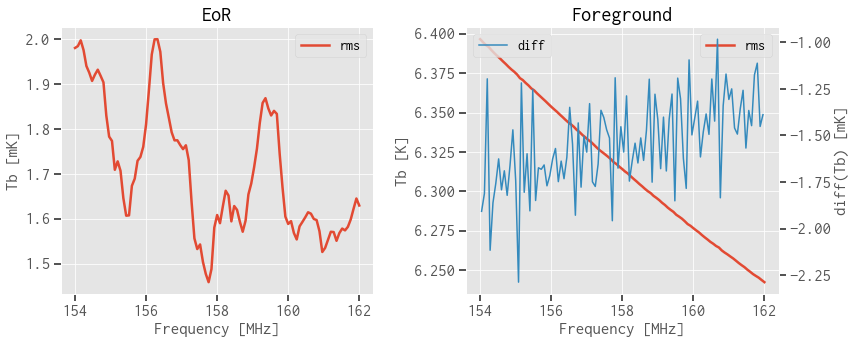

In [132]:
def plot_cubes(cube_eor, cube_fg):
    nfreq = cube_eor.shape[0]
    freqs = np.linspace(154, 162, nfreq)
    fmid = (freqs[1:] + freqs[:-1]) / 2
    
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))

    ax = ax0
    eor_rms = rms(cube_eor, axis=(1,2)) * 1e3  # mK
    ax.plot(freqs, eor_rms, lw=2.5, label='rms')
    ax.legend()
    ax.set(xlabel='Frequency [MHz]', ylabel='Tb [mK]', title='EoR')

    ax = ax1
    fg_rms = rms(cube_fg, axis=(1,2))
    ax.plot(freqs, fg_rms, lw=2.5, label='rms')
    ax.legend()
    ax.set(xlabel='Frequency [MHz]', ylabel='Tb [K]', title='Foreground')
    ax_ = ax.twinx()
    ax_.plot(fmid, np.diff(fg_rms)*1e3, color='C1', label='diff')
    ax_.legend()
    ax_.set(ylabel='diff(Tb) [mK]')
    ax_.grid(False)

    fig.tight_layout()
    plt.show()
    
    
plot_cubes(cube_eor2, cube_fg2)

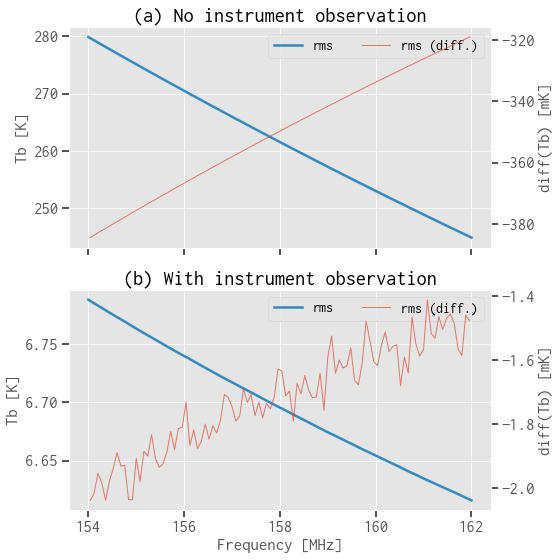

figure saved to file: /home/aly/git/cdae-eor/code/simudata.pdf


In [17]:
def plot_simudata(cube, skycube, figsize=(8, 12)):
    nf, ny, nx = cube.shape
    f = np.linspace(154, 162, nf)
    f2 = (f[1:] + f[:-1]) / 2

    fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=figsize, sharex=True)

    xlabel = 'Frequency [MHz]'
    ylabel = 'Tb [K]'
    ylabel2 = 'diff(Tb) [mK]'
    ax0.set(ylabel=ylabel,
            title='(a) No instrument observation')
    ax0_ = ax0.twinx()
    ax0_.set_ylabel(ylabel2)
    ax0_.grid(False)
    
    ax1.set(xlabel=xlabel, ylabel=ylabel,
            title='(b) With instrument observation')
    ax1_ = ax1.twinx()
    ax1_.set_ylabel(ylabel2)
    ax1_.grid(False)
    
    y = rms(skycube, axis=(1,2))
    ax0.plot(f, y, color='C1', lw=2.5, label='rms')
    y2 = np.diff(y) * 1e3  # [mK]
    ax0_.plot(f2, y2, color='C0', lw=1, alpha=0.7, label='rms (diff.)')
    
    y = rms(cube, axis=(1,2))
    y = np.abs(y)
    ax1.plot(f, y, color='C1', lw=2.5, label='rms')
    y2 = np.diff(y) * 1e3  # [mK]
    ax1_.plot(f2, y2, color='C0', lw=1, alpha=0.7, label='rms (diff.)')
    
    h1, l1 = ax0.get_legend_handles_labels()
    h2, l2 = ax0_.get_legend_handles_labels()
    ax0.legend(h1+h2, l1+l2, ncol=2, loc='upper right')
    
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax1_.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, ncol=2, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    return fig, (ax0, ax1)


fig, axes = plot_simudata(cube_fg, skycube_fg, figsize=(8, 8))
if True:
    fn = 'simudata.pdf'
    fig.savefig(fn)
    print('figure saved to file: %s' % path.abspath(fn))

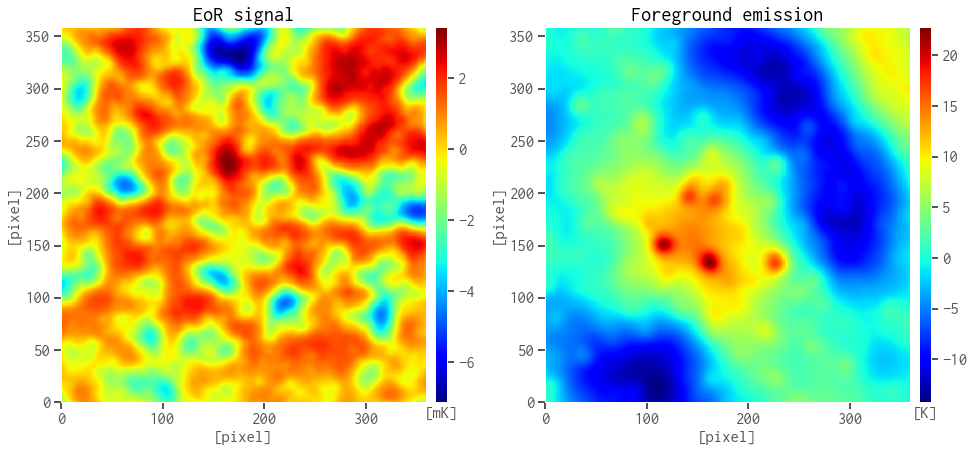

figure saved to: /home/aly/git/cdae-eor/code/obsimg-158.png


In [134]:
def plot_slice(cube_eor, cube_fg, i=50, figsize=(14, 6.5)):
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=figsize)

    ax = ax0
    slc_eor = cube_eor[i, :, :]
    nx, ny = slc_eor.shape
    mappable = ax.pcolormesh(np.arange(nx), np.arange(ny), slc_eor*1e3, cmap='jet')
    vmin, vmax = mappable.get_clim()
    cb = ax.figure.colorbar(mappable, ax=ax, pad=0.02, aspect=30)
    cb.ax.set_xlabel('[mK]')
    ax.set(title='EoR signal', xlabel='[pixel]', ylabel='[pixel]')

    ax = ax1
    slc_fg = cube_fg[i, :, :]
    nx, ny = slc_fg.shape
    mappable = ax.pcolormesh(np.arange(nx), np.arange(ny), slc_fg, cmap='jet')
    vmin, vmax = mappable.get_clim()
    cb = ax.figure.colorbar(mappable, ax=ax, pad=0.02, aspect=30)
    cb.ax.set_xlabel('[K]')
    ax.set(title='Foreground emission', xlabel='[pixel]', ylabel='[pixel]')

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.1)
    plt.show()
    return (fig, (ax0, ax1))


fig, axes = plot_slice(cube_eor, cube_fg)
if True:
    fn = 'obsimg-158.png'
    fig.savefig(fn, dpi=120)
    print(f'figure saved to: {path.abspath(fn)}')

---

## 4. Preprocessing

In [18]:
cube_tot  = cube_fg  + cube_eor
cube_tot2 = cube_fg2 + cube_eor2

In [19]:
z_eor  = calc_rfft(cube_eor)
z_tot  = calc_rfft(cube_tot)
z_fg   = calc_rfft(cube_fg)

z_eor2 = calc_rfft(cube_eor2)
z_tot2 = calc_rfft(cube_tot2)
z_fg2  = calc_rfft(cube_fg2)

In [20]:
# number of lowest Fourier coefficients to be excised
nex = 6

zen_eor  = rfft_encode2(z_eor, nex=nex)
zen_tot  = rfft_encode2(z_tot, nex=nex)
zen_fg   = rfft_encode2(z_fg,  nex=nex)

zen_eor2 = rfft_encode2(z_eor2, nex=nex)
zen_tot2 = rfft_encode2(z_tot2, nex=nex)
zen_fg2  = rfft_encode2(z_fg2,  nex=nex)

npix, nfreq = zen_eor.shape

In [21]:
x_data, x_label,      x_fg      = normalize_ds(zen_tot,  zen_eor,  zen_fg)
x_test, x_test_label, x_test_fg = normalize_ds(zen_tot2, zen_eor2, zen_fg2)

---

## 5. CDAE Method

### 5.1. Dataset partition

In [22]:
idx = np.arange(npix)
np.random.seed(42)
np.random.shuffle(idx)

frac_validate = 0.2
n_validate = int(npix * frac_validate)
n_train = npix - n_validate

idx_train = idx[:n_train]
idx_validate = idx[-n_validate:]

x_train       = x_data [idx_train, :, np.newaxis]
x_train_label = x_label[idx_train, :, np.newaxis]
x_train_fg    = x_fg   [idx_train, :, np.newaxis]

x_validate       = x_data [idx_validate, :, np.newaxis]
x_validate_label = x_label[idx_validate, :, np.newaxis]
x_validate_fg    = x_fg   [idx_validate, :, np.newaxis]

x_test       = x_test      [:, :, np.newaxis]
x_test_label = x_test_label[:, :, np.newaxis]
x_test_fg    = x_test_fg   [:, :, np.newaxis]

[x_train.shape, x_validate.shape, x_test.shape]

[(103680, 90, 1), (25920, 90, 1), (129600, 90, 1)]

### 5.2. Architecture

In [24]:
f_act = 'elu'  # exponential linear unit
init_method = 'he_uniform'
padding = 'same'

In [118]:
try:
    del model
except NameError:
    pass
else:
    K.clear_session()

model = Sequential()

model.add(Conv1D(32, 3, activation=f_act, padding=padding, kernel_initializer=init_method,
                 input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation=f_act, padding=padding, kernel_initializer=init_method))

model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation=f_act, padding=padding, kernel_initializer=init_method))

model.add(BatchNormalization())
model.add(Conv1D( 1, 3, activation='tanh', padding=padding))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 90, 32)            128       
_________________________________________________________________
batch_normalization_1 (Batch (None, 90, 32)            128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 90, 64)            6208      
_________________________________________________________________
batch_normalization_2 (Batch (None, 90, 64)            256       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 90, 64)            12352     
_________________________________________________________________
batch_normalization_3 (Batch (None, 90, 64)            256       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 90, 32)            6176      
__________

### 5.3. Training

In [119]:
modelfit = ModelFit(
    model,
    train_data=(x_train, x_train_label),
    val_data=(x_validate, x_validate_label),
    test_data=(x_test, x_test_label),
    lr=1e-5,
)

In [120]:
modelfit.fit(epochs=50)

*** epoch *** 1/50 ***
    eval[validation]: 0.7630 +/- 0.0865
    eval[test]: 0.7445 +/- 0.0929
> loss: 0.1020, 0.0316 // time: 21.2, 3.9, 40.1
*** epoch *** 2/50 ***
    eval[validation]: 0.8618 +/- 0.0562
    eval[test]: 0.8405 +/- 0.0668
> loss: 0.0234, 0.0184 // time: 17.9, 3.7, 36.9
*** epoch *** 3/50 ***
    eval[validation]: 0.8980 +/- 0.0446
    eval[test]: 0.8754 +/- 0.0570
> loss: 0.0157, 0.0136 // time: 17.8, 3.8, 36.6
*** epoch *** 4/50 ***
    eval[validation]: 0.9149 +/- 0.0394
    eval[test]: 0.8915 +/- 0.0532
> loss: 0.0124, 0.0113 // time: 17.9, 3.9, 36.9
*** epoch *** 5/50 ***
    eval[validation]: 0.9239 +/- 0.0368
    eval[test]: 0.9005 +/- 0.0503
> loss: 0.0107, 0.0100 // time: 17.8, 3.9, 36.7
*** epoch *** 6/50 ***
    eval[validation]: 0.9303 +/- 0.0348
    eval[test]: 0.9065 +/- 0.0489
> loss: 0.0097, 0.0092 // time: 17.9, 3.9, 36.5
*** epoch *** 7/50 ***
    eval[validation]: 0.9342 +/- 0.0337
    eval[test]: 0.9102 +/- 0.0481
> loss: 0.0090, 0.0086 // time: 1

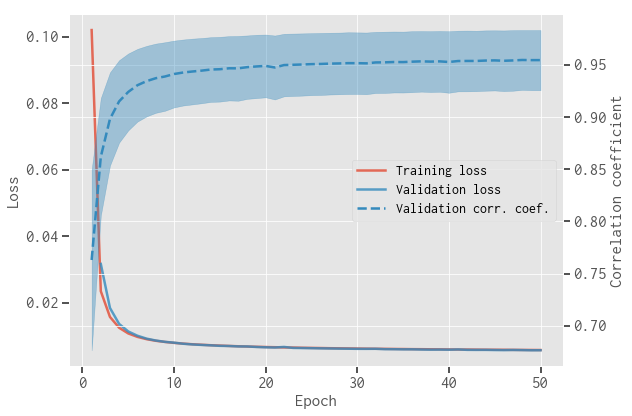

figure saved to file: /home/aly/git/cdae-eor/code/cdae-train.pdf


In [121]:
fig, axes = plot_modelfit(modelfit, figsize=(9, 6))
if True:
    fn = 'cdae-train.pdf'
    fig.savefig(fn)
    print('figure saved to file: %s' % path.abspath(fn))

In [122]:
model = modelfit.model

# Save model in variables
model_arch = model.to_json()
weights = model.get_weights()

In [153]:
# Save model to file

now = datetime.now().strftime('%Y%m%dT%H%M')
modelfile = f'cdae.{now}.hdf5'
modelfit.model.save(modelfile)
print(f'Saved model to file: {path.abspath(modelfile)}')

Saved model to file: /home/aly/git/cdae-eor/code/cdae.20181212T1847.hdf5


In [ ]:
# Recover model from variables

K.clear_session()
model = keras.models.model_from_json(model_arch)
model.set_weights(weights)

In [ ]:
# Reload model from file

K.clear_session()
modelfile = 'eor-detection-cdae.???.hdf5'
model = keras.models.load_model(modelfile)

### 5.4. Results

In [124]:
x_test_pred = model.predict(x_test)
cc_test = corrcoef_ds(x_test_pred[:, :, 0], x_test_label[:, :, 0])
a_summary(cc_test)

min: 0.5886685252189636
max: 0.9930587410926819
mean: 0.9285510809581589
std: 0.04517542453926809
median: 0.9399302005767822


In [125]:
zde_test_label = rfft_decode2(x_test_label[:, :, 0], nex=nex)
zde_test_pred  = rfft_decode2(x_test_pred[ :, :, 0], nex=nex)

nk = zde_test_label.shape[1]
k = np.arange(nk)

ps1_label = k[np.newaxis, :] * np.abs(zde_test_label)**2
ps1_pred  = k[np.newaxis, :] * np.abs(zde_test_pred)**2

p1_label = np.sum(ps1_label, axis=1)
p1_pred  = np.sum(ps1_pred,  axis=1)

pr = p1_pred / p1_label
a_summary(pr)

min: 0.45306933098108837
max: 2.1297430733277873
mean: 0.9263819836385373
std: 0.14574083215637007
median: 0.9087754983272605


In [69]:
n_test = x_test.shape[0]
tpix = np.random.randint(0, n_test, size=1)[0]
tpix

105069

corrcoef(tpred, tlabel): 0.9307371377944946
corrcoef(spred, slabel): 0.9307898856410688


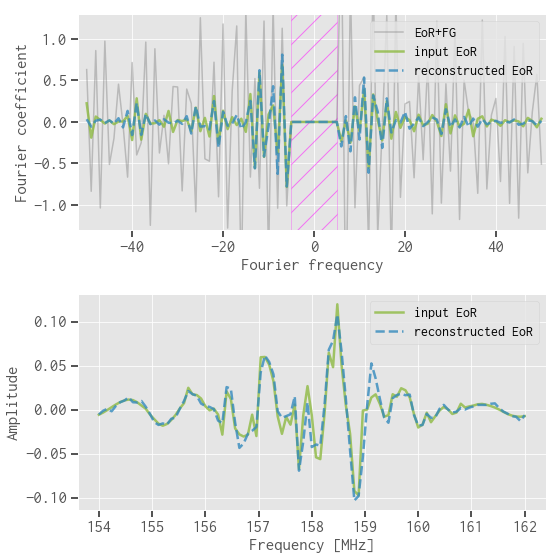

figure saved to file: /home/aly/git/cdae-eor/code/eor-result.pdf


In [128]:
fig, axes = plot_modelresult(tpix, x_test, x_test_label, x_test_pred, nex=nex)
if False:
    fn = 'eor-result.pdf'
    fig.savefig(fn)
    print('figure saved to file: %s' % path.abspath(fn))

### 5.5. More results

In [17]:
def irfft_cube(x, nex):
    npix, nf, __ = x.shape
    nf0 = nf + 2*nex - 1
    n = int(npix**0.5)
    z = rfft_decode2(x[:, :, 0], nex=nex)  # [npix, nf*]
    y = np.fft.irfft(z, n=nf0, axis=1)  # [npix, nf0]
    y2 = np.swapaxes(y, 0, 1)  # [nf0, npix]
    return y2.reshape((nf0, n, n))


def plot_slice_eor(cube_in, cube_out, i=50, figsize=(12, 6)):
    slc_in  = cube_in[i, :, :]
    slc_out = cube_out[i, :, :]
    nx, ny  = slc_in.shape
    vmin, vmax = np.min(slc_in), np.max(slc_out)

    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    ax = axes[0]
    mappable = ax.pcolormesh(np.arange(nx), np.arange(ny), slc_in, cmap='jet',
                             vmin=vmin, vmax=vmax)
    ax.set(title='Input EoR', xlabel='[pixel]', ylabel='[pixel]')

    ax = axes[1]
    mappable = ax.pcolormesh(np.arange(nx), np.arange(ny), slc_out, cmap='jet',
                             vmin=vmin, vmax=vmax)
    ax.set(title='Reconstructed EoR', xlabel='[pixel]')
    ax.yaxis.set_ticklabels([])

    fig.subplots_adjust(top=1, bottom=0, left=0, right=0.97, wspace=0.05)
    
    cax = fig.add_axes([0.98, 0.0, 0.02, 1.0])  # [left, bottom, width, height]
    cb = fig.colorbar(mappable, cax=cax)
    cb.ax.set_xlabel('Amplitude')
    cb.ax.xaxis.labelpad = 30

    plt.show()
    return (fig, axes)

In [136]:
cin_eor  = irfft_cube(x_test_label, nex=nex)
cout_eor = irfft_cube(x_test_pred,  nex=nex)

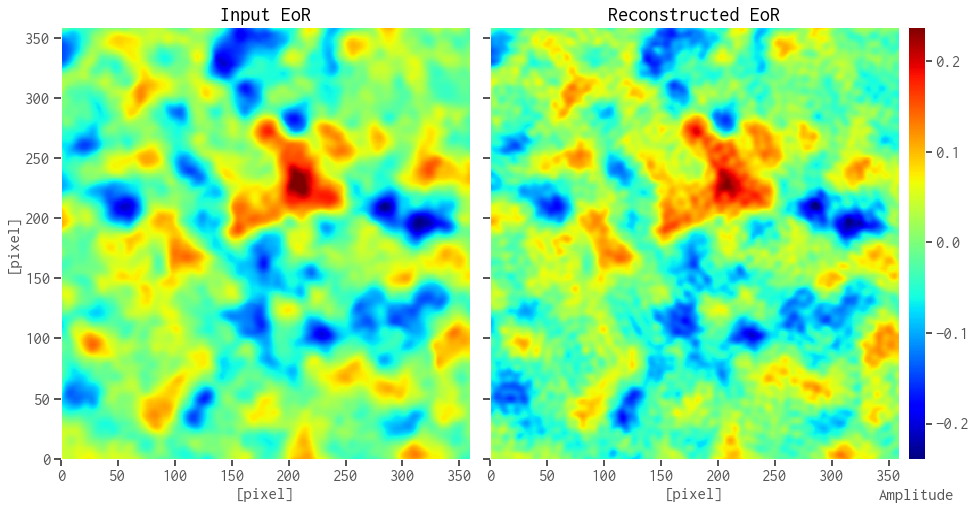

figure saved to file: /home/aly/git/cdae-eor/code/eor-img-comp.png


In [141]:
# 158 MHz image of reconstructed EoR

fig, axes = plot_slice_eor(cin_eor, cout_eor)
if True:
    fn = 'eor-img-comp.png'
    fig.savefig(fn, bbox_inches='tight', dpi=150)
    print('figure saved to file: %s' % path.abspath(fn))

In [143]:
def calc_ps2d(cube, fmin=154, fmax=162, fov=2):
    f21cm = 1420.405751  # [MHz]
    cosmo = FlatLambdaCDM(H0=71, Om0=0.27)
    nf, ny, nx = cube.shape
    fc = (fmin + fmax) / 2
    zc = f21cm / fc - 1
    DM = cosmo.comoving_transverse_distance(zc).value  # [Mpc]
    
    pixelsize = fov / nx  # [deg]
    d_xy = DM * np.deg2rad(pixelsize)  # [Mpc]
    fs_xy = 1 / d_xy  # [Mpc^-1]
    
    dfreq = (fmax - fmin) / (nf-1)  # [MHz]
    c = ac.c.to("km/s").value
    H = cosmo.H(zc).value  # [km/s/Mpc]
    d_z = c * (1+zc)**2 * dfreq / H / f21cm  # [Mpc]
    fs_z = 1 / d_z  # [Mpc^-1]
    
    cubefft = fftpack.fftshift(fftpack.fftn(cube))
    ps3d = np.abs(cubefft) ** 2  # [K^2]
    norm1 = 1 / (nx * ny * nf)
    norm2 = 1 / (fs_xy**2 * fs_z)  # [Mpc^3]
    norm3 = 1 / (2*np.pi)**3
    ps3d *= (norm1 * norm2 * norm3)  # [K^2 Mpc^3]
    
    k_xy = 2*np.pi * fftpack.fftshift(fftpack.fftfreq(nx, d=d_xy))
    k_z  = 2*np.pi * fftpack.fftshift(fftpack.fftfreq(nf, d=d_z))
    k_perp = k_xy[k_xy >= 0]
    k_los  = k_z [k_z  >= 0]
    n_k_perp = len(k_perp)
    n_k_los  = len(k_los)
    ps2d = np.zeros(shape=(n_k_los, n_k_perp))

    eps = 1e-8
    ic_xy = (np.abs(k_xy) < eps).nonzero()[0][0]
    ic_z  = (np.abs(k_z)  < eps).nonzero()[0][0]
    p_xy = np.arange(nx) - ic_xy
    p_z  = np.abs(np.arange(nf) - ic_z)
    mx, my = np.meshgrid(p_xy, p_xy)
    rho = np.sqrt(mx**2 + my**2)
    rho = np.around(rho).astype(int)

    for r in range(n_k_perp):
        ix, iy = (rho == r).nonzero()
        for s in range(n_k_los):
            iz = (p_z == s).nonzero()[0]
            cells = np.concatenate([ps3d[z, iy, ix] for z in iz])
            ps2d[s, r] = cells.mean()
            
    return (ps2d, k_perp, k_los)


def plot_ps2d(data, k_perp, k_los, ax,
              colorbar=True, vmin=None, vmax=None,
              k_perp_lim=None, k_los_lim=None):
    # data shape: [n_k_los, n_k_perp]
    mappable = ax.pcolormesh(k_perp[1:], k_los[1:], np.log10(data[1:, 1:]),
                             vmin=vmin, vmax=vmax, cmap='jet')
    k_perp_lim = k_perp_lim or (k_perp[1], k_perp[-1])
    k_los_lim = k_los_lim or (k_los[1], k_los[-1])
    ax.set(xscale='log', yscale='log',
           xlim=k_perp_lim, ylim=k_los_lim,
           xlabel=r'$k_{\perp}$ [Mpc$^{-1}$]',
           ylabel=r'$k_{||}$ [Mpc$^{-1}$]')

    cb = None
    if colorbar:
        # https://stackoverflow.com/a/25983372/4856091
        def expfmt_(x, pos):
            return '$\\mathdefault{10^{%.0f}}$' % float(x)
        expfmt = mpl.ticker.FuncFormatter(expfmt_)
    
        cb = ax.figure.colorbar(mappable, ax=ax, pad=0.01, aspect=30, format=expfmt)
        cb.ax.set_xlabel('Power')
        cb.ax.xaxis.labelpad = 10
        
    return (mappable, cb)

In [144]:
ps2d_in,  k_perp, k_los = calc_ps2d(cin_eor)
ps2d_out, k_perp, k_los = calc_ps2d(cout_eor)

ps2d_in.shape, k_perp.shape, k_los.shape

/home/aly/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


((51, 180), (180,), (51,))

figure saved to file: /home/aly/git/cdae-eor/code/eor-ps-comp.png


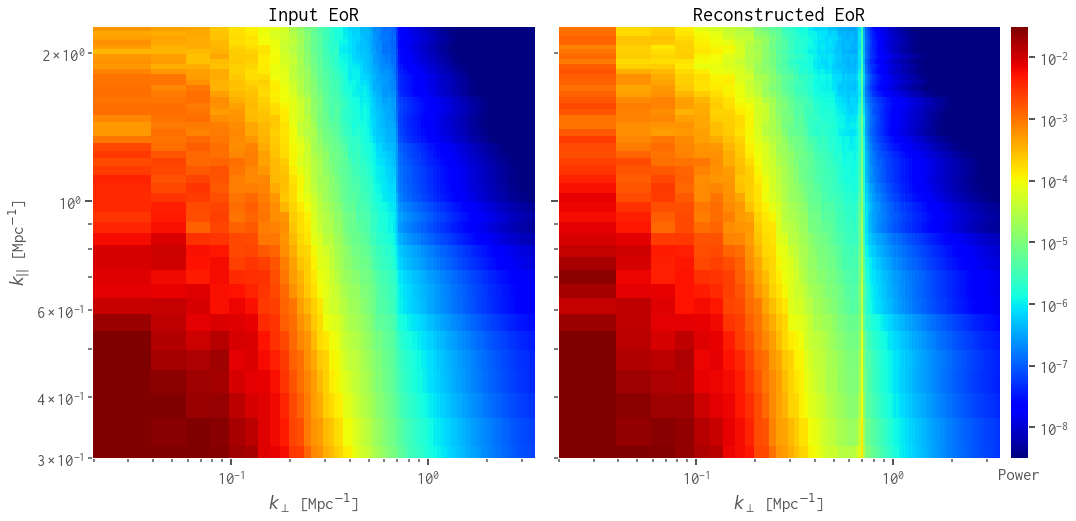

In [145]:
k_perp_lim = (k_perp[1], k_perp[-1])
k_los_lim  = (0.3, k_los[-1])

def expfmt_(x, pos):
    return '$\\mathdefault{10^{%.0f}}$' % float(x)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(13, 6))

plot_ps2d(ps2d_in, k_perp, k_los, colorbar=False,
          ax=ax0, vmin=-8.5, vmax=-1.5,
          k_perp_lim=k_perp_lim, k_los_lim=k_los_lim)
ax0.set(title='Input EoR')

mappable, __ = plot_ps2d(
    ps2d_out, k_perp, k_los, colorbar=False,
    ax=ax1, vmin=-8.5, vmax=-1.5,
    k_perp_lim=k_perp_lim, k_los_lim=k_los_lim,
)
ax1.set(title='Reconstructed EoR', ylabel='')
ax1.set_yticklabels([], minor=False)
ax1.set_yticklabels([], minor=True)

fig.subplots_adjust(top=1, bottom=0, left=0, right=0.97, wspace=0.05)    
cax = fig.add_axes([0.98, 0.0, 0.02, 1.0])  # [left, bottom, width, height]
cb = fig.colorbar(mappable, cax=cax, format=mpl.ticker.FuncFormatter(expfmt_))
cb.ax.set_xlabel('Power')
cb.ax.xaxis.labelpad = 10

if True:
    fn = 'eor-ps-comp.png'
    fig.savefig(fn, bbox_inches='tight', dpi=150)
    print('figure saved to file: %s' % path.abspath(fn))
else:
    plt.show()

### 5.6. Structures explanation

* Small ripples in the reconstructed EoR image
* The bright stripe in the 2D power spectrum

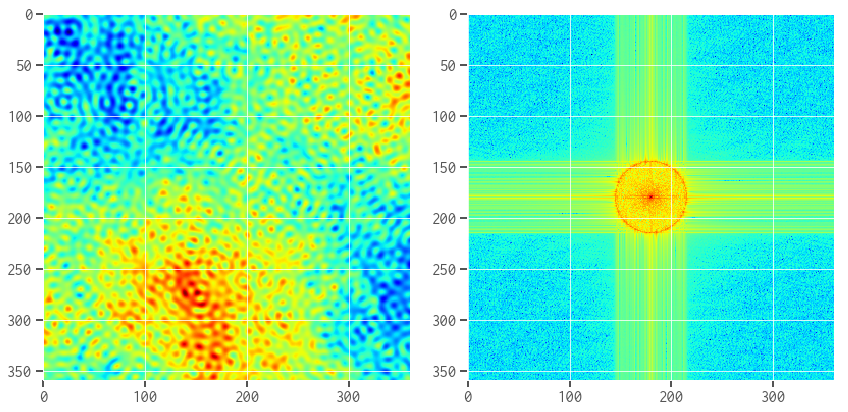

In [23]:
cin_fg = irfft_cube(x_test_fg, nex=nex)
slcin_fg = cin_fg[50, :, :]
ftin_fg = np.fft.fftshift(np.fft.fft2(slcin_fg))

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 6))
ax0.imshow(slcin_fg)
ax1.imshow(np.log10(np.abs(ftin_fg)**2))
fig.tight_layout()
plt.show()

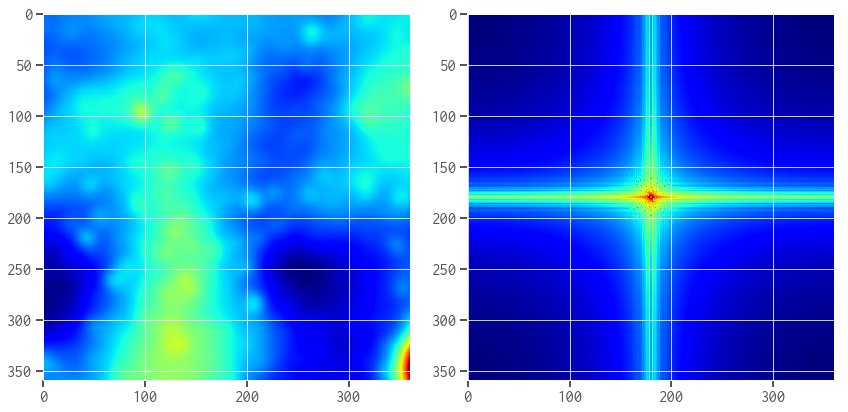

In [24]:
slc_fg = cube_fg2[50, :, :]
ft_fg = np.fft.fftshift(np.fft.fft2(slc_fg))

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 6))
ax0.imshow(slc_fg)
ax1.imshow(np.log10(np.abs(ft_fg)**2))
fig.tight_layout()
plt.show()

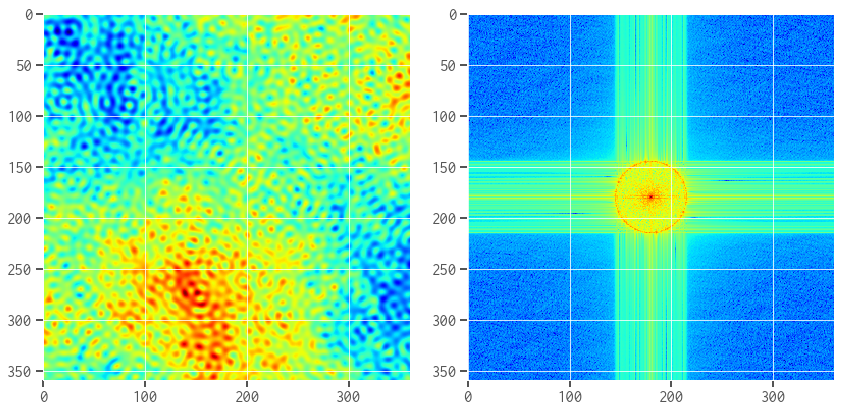

In [26]:
nfreq0 = cube_fg2.shape[0]
window = signal.nuttall(nfreq0, sym=False)
cw_fg2 = cube_fg2 * window[:, np.newaxis, np.newaxis]
rft_fg2 = np.fft.rfft(cw_fg2, axis=0)

rft_fg2[:nex, :, :] = 0
cw2_fg2 = np.fft.irfft(rft_fg2, n=nfreq0, axis=0)

slc_fg2 = cw2_fg2[50, :, :]
ft_fg2 = np.fft.fftshift(np.fft.fft2(slc_fg2))

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 6))
ax0.imshow(slc_fg2)
ax1.imshow(np.log10(np.abs(ft_fg2)**2))
fig.tight_layout()
plt.show()

---

## 6. Comparisons

## 6.1. With pooling layers

In [74]:
try:
    del model1
except NameError:
    pass
else:
    K.clear_session()

model1 = Sequential()

model1.add(Conv1D(32, 3, activation=f_act, padding=padding, kernel_initializer=init_method,
                  input_shape=x_train.shape[1:]))
model1.add(BatchNormalization())
model1.add(Conv1D(64, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model1.add(MaxPool1D(2, padding=padding))
model1.add(BatchNormalization())
model1.add(Conv1D(64, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model1.add(MaxPool1D(2, padding=padding))
model1.add(BatchNormalization())
model1.add(Conv1D(32, 3, activation=f_act, padding=padding, kernel_initializer=init_method))

model1.add(BatchNormalization())
model1.add(Conv1D(32, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model1.add(UpSampling1D(2))
model1.add(BatchNormalization())
model1.add(Conv1D(64, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model1.add(UpSampling1D(2))
model1.add(BatchNormalization())
model1.add(Conv1D(64, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model1.add(BatchNormalization())
model1.add(Conv1D(32, 3, activation=f_act, padding=padding, kernel_initializer=init_method))

model1.add(BatchNormalization())
model1.add(Conv1D( 1, 3, activation='tanh', padding='valid'))

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 90, 32)            128       
_________________________________________________________________
batch_normalization_1 (Batch (None, 90, 32)            128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 90, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 45, 64)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 45, 64)            256       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 45, 64)            12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 23, 64)            0         
__________

In [75]:
modelfit1 = ModelFit(
    model1,
    train_data=(x_train, x_train_label),
    val_data=(x_validate, x_validate_label),
    test_data=(x_test, x_test_label),
    lr=1e-5,
)

In [76]:
modelfit1.fit(epochs=50)

*** epoch *** 1/50 ***
    eval[validation]: 0.5050 +/- 0.1197
    eval[test]: 0.4819 +/- 0.1254
> loss: 0.1566, 0.0627, // time: 23.4, 4.8, 46.1
*** epoch *** 2/50 ***
    eval[validation]: 0.7507 +/- 0.0799
    eval[test]: 0.7236 +/- 0.0906
> loss: 0.0443, 0.0320, // time: 19.6, 4.6, 42.3
*** epoch *** 3/50 ***
    eval[validation]: 0.8443 +/- 0.0561
    eval[test]: 0.8170 +/- 0.0702
> loss: 0.0257, 0.0207, // time: 19.4, 4.6, 41.8
*** epoch *** 4/50 ***
    eval[validation]: 0.8866 +/- 0.0448
    eval[test]: 0.8594 +/- 0.0604
> loss: 0.0178, 0.0152, // time: 19.6, 4.6, 42.5
*** epoch *** 5/50 ***
    eval[validation]: 0.9087 +/- 0.0392
    eval[test]: 0.8816 +/- 0.0552
> loss: 0.0138, 0.0122, // time: 19.5, 4.6, 42.5
*** epoch *** 6/50 ***
    eval[validation]: 0.9214 +/- 0.0362
    eval[test]: 0.8945 +/- 0.0520
> loss: 0.0114, 0.0104, // time: 19.7, 4.6, 42.7
*** epoch *** 7/50 ***
    eval[validation]: 0.9297 +/- 0.0339
    eval[test]: 0.9028 +/- 0.0498
> loss: 0.0100, 0.0093, // 

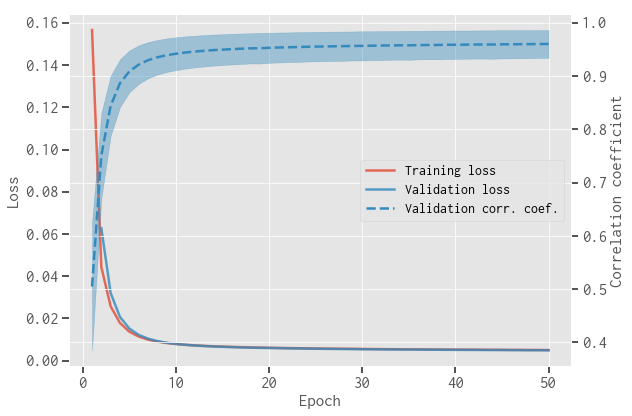

figure saved to file: /home/aly/git/cdae-eor/code/cdae-train-pooling.pdf


In [78]:
fig, axes = plot_modelfit(modelfit1, figsize=(9, 6))
if False:
    fn = 'cdae-train-pooling.pdf'
    fig.savefig(fn)
    print('figure saved to file: %s' % path.abspath(fn))

In [ ]:
model1 = modelfit1.model
model1_arch = model1.to_json()
weights1 = model1.get_weights()

now = datetime.now().strftime('%Y%m%dT%H%M')
modelfile = f'cdae.pooling.{now}.hdf5'
modelfit2.model.save(modelfile)
print(f'Saved model to file: {path.abspath(modelfile)}')

In [79]:
x_test_pred1 = modelfit1.model.predict(x_test)
cc1_test = corrcoef_ds(x_test_pred1[:, :, 0], x_test_label[:, :, 0])
a_summary(cc1_test)

min: 0.5861849188804626
max: 0.9943709373474121
mean: 0.9317800079571245
std: 0.04388938729344912
median: 0.9429926872253418


## 6.2. Without Fourier Transform

In [81]:
def preprocess_ds_noft(cube_tot, cube_eor, q=(1, 99)):
    nf, ny, nx = cube_tot.shape
    x_data  = np.swapaxes(np.array(cube_tot.reshape((nf, ny*nx))), 0, 1)
    x_label = np.swapaxes(np.array(cube_eor.reshape((nf, ny*nx))), 0, 1)
    if nf % 2 == 1:
        # Make the number of frequencies even to avoid hacking the paddings.
        x_data  = x_data [:, :-1]
        x_label = x_label[:, :-1]

    x_data -= np.mean(x_data, axis=1, keepdims=True)
    x_data /= np.std(x_data)
    
    x_label -= np.mean(x_label, axis=1, keepdims=True)
    vlow, vhigh = np.percentile(x_label, q=q)
    x_label[x_label < vlow]  = vlow
    x_label[x_label > vhigh] = vhigh
    x_label /= max(abs(vlow), abs(vhigh))
    
    return (x_data, x_label)

In [82]:
x2_data, x2_label      = preprocess_ds_noft(cube_tot,  cube_eor)
x2_test, x2_test_label = preprocess_ds_noft(cube_tot2, cube_eor2)

x2_train          = x2_data [idx_train,    :, np.newaxis]
x2_train_label    = x2_label[idx_train,    :, np.newaxis]
x2_validate       = x2_data [idx_validate, :, np.newaxis]
x2_validate_label = x2_label[idx_validate, :, np.newaxis]

x2_test = x2_test[:, :, np.newaxis]
x2_test_label = x2_test_label[:, :, np.newaxis]

x2_train.shape, x2_validate.shape, x2_test.shape

((103680, 100, 1), (25920, 100, 1), (129600, 100, 1))

In [84]:
try:
    del model2
except NameError:
    pass
else:
    K.clear_session()

model2 = Sequential()

model2.add(Conv1D(32, 3, activation=f_act, padding=padding, kernel_initializer=init_method,
                  input_shape=x2_train.shape[1:]))
model2.add(BatchNormalization())
model2.add(Conv1D(64, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model2.add(BatchNormalization())
model2.add(Conv1D(64, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model2.add(BatchNormalization())
model2.add(Conv1D(32, 3, activation=f_act, padding=padding, kernel_initializer=init_method))

model2.add(BatchNormalization())
model2.add(Conv1D(32, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model2.add(BatchNormalization())
model2.add(Conv1D(64, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model2.add(BatchNormalization())
model2.add(Conv1D(64, 3, activation=f_act, padding=padding, kernel_initializer=init_method))
model2.add(BatchNormalization())
model2.add(Conv1D(32, 3, activation=f_act, padding=padding, kernel_initializer=init_method))

model2.add(BatchNormalization())
model2.add(Conv1D( 1, 3, activation='tanh', padding=padding))

In [88]:
modelfit2 = ModelFit(
    model2,
    train_data=(x2_train, x2_train_label),
    val_data=(x2_validate, x2_validate_label),
    test_data=(x2_test, x2_test_label),
    lr=1e-5,
)

In [89]:
modelfit2.fit(epochs=50)

*** epoch *** 1/50 ***
    eval[validation]: 0.2392 +/- 0.1358
    eval[test]: 0.2119 +/- 0.1567
> loss: 0.1821, 0.1134, // time: 22.5, 4.5, 44.4
*** epoch *** 2/50 ***
    eval[validation]: 0.3676 +/- 0.1594
    eval[test]: 0.3335 +/- 0.1763
> loss: 0.1076, 0.0982, // time: 18.7, 4.4, 40.4
*** epoch *** 3/50 ***
    eval[validation]: 0.4411 +/- 0.1636
    eval[test]: 0.3928 +/- 0.1897
> loss: 0.0967, 0.0908, // time: 18.7, 4.4, 40.5
*** epoch *** 4/50 ***
    eval[validation]: 0.4854 +/- 0.1583
    eval[test]: 0.4363 +/- 0.1815
> loss: 0.0909, 0.0863, // time: 18.6, 4.4, 40.4
*** epoch *** 5/50 ***
    eval[validation]: 0.5088 +/- 0.1659
    eval[test]: 0.4644 +/- 0.1843
> loss: 0.0870, 0.0838, // time: 18.5, 4.3, 40.4
*** epoch *** 6/50 ***
    eval[validation]: 0.5297 +/- 0.1636
    eval[test]: 0.4883 +/- 0.1794
> loss: 0.0842, 0.0816, // time: 18.5, 4.4, 40.5
*** epoch *** 7/50 ***
    eval[validation]: 0.5453 +/- 0.1671
    eval[test]: 0.4908 +/- 0.1950
> loss: 0.0820, 0.0793, // 

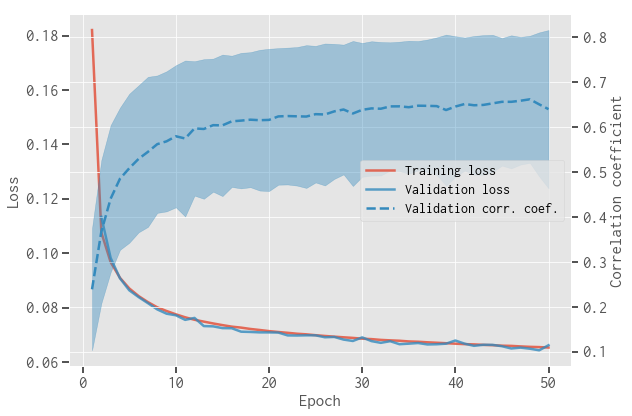

figure saved to file: /home/aly/git/cdae-eor/code/cdae-train-noft.pdf


In [91]:
fig, axes = plot_modelfit(modelfit2, figsize=(9, 6))

In [94]:
x2_test_pred2 = model2.predict(x2_test)
cc2_test = corrcoef_ds(x2_test_pred2[:, :, 0], x2_test_label[:, :, 0])
a_summary(cc2_test)

min: -0.3965127766132355
max: 0.9325503706932068
mean: 0.5989353035257013
std: 0.18576200717965152
median: 0.6389830112457275


In [95]:
modelfit2.fit(epochs=20)

*** epoch *** 51/70 ***
    eval[validation]: 0.6634 +/- 0.1439
    eval[test]: 0.6025 +/- 0.1694
> loss: 0.0652, 0.0641, // time: 18.8, 4.3, 40.7
*** epoch *** 52/70 ***
    eval[validation]: 0.6621 +/- 0.1457
    eval[test]: 0.6087 +/- 0.1656
> loss: 0.0651, 0.0644, // time: 18.3, 4.5, 40.3
*** epoch *** 53/70 ***
    eval[validation]: 0.6603 +/- 0.1496
    eval[test]: 0.6028 +/- 0.1732
> loss: 0.0649, 0.0646, // time: 18.5, 4.5, 40.2
*** epoch *** 54/70 ***
    eval[validation]: 0.6534 +/- 0.1623
    eval[test]: 0.6061 +/- 0.1755
> loss: 0.0648, 0.0657, // time: 18.5, 4.3, 40.5
*** epoch *** 55/70 ***
    eval[validation]: 0.6577 +/- 0.1580
    eval[test]: 0.6025 +/- 0.1786
> loss: 0.0647, 0.0650, // time: 18.3, 4.4, 40.2
*** epoch *** 56/70 ***
    eval[validation]: 0.6547 +/- 0.1656
    eval[test]: 0.6080 +/- 0.1781
> loss: 0.0646, 0.0655, // time: 18.4, 4.4, 40.8
*** epoch *** 57/70 ***
    eval[validation]: 0.6603 +/- 0.1557
    eval[test]: 0.6107 +/- 0.1709
> loss: 0.0645, 0.06

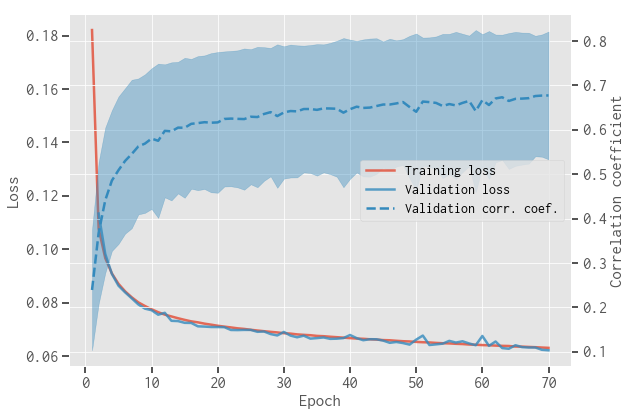

In [96]:
fig, axes = plot_modelfit(modelfit2, figsize=(9, 6))

In [97]:
modelfit2.fit(epochs=30)

*** epoch *** 71/100 ***
    eval[validation]: 0.6778 +/- 0.1427
    eval[test]: 0.6106 +/- 0.1729
> loss: 0.0629, 0.0618, // time: 18.7, 4.5, 40.2
*** epoch *** 72/100 ***
    eval[validation]: 0.6760 +/- 0.1454
    eval[test]: 0.6177 +/- 0.1695
> loss: 0.0629, 0.0624, // time: 18.6, 4.5, 40.7
*** epoch *** 73/100 ***
    eval[validation]: 0.6801 +/- 0.1389
    eval[test]: 0.6167 +/- 0.1673
> loss: 0.0628, 0.0616, // time: 18.5, 4.4, 40.5
*** epoch *** 74/100 ***
    eval[validation]: 0.6795 +/- 0.1403
    eval[test]: 0.6162 +/- 0.1691
> loss: 0.0627, 0.0617, // time: 18.5, 4.4, 40.6
*** epoch *** 75/100 ***
    eval[validation]: 0.6554 +/- 0.1759
    eval[test]: 0.6086 +/- 0.1883
> loss: 0.0626, 0.0655, // time: 18.5, 4.4, 40.5
*** epoch *** 76/100 ***
    eval[validation]: 0.6776 +/- 0.1442
    eval[test]: 0.6168 +/- 0.1692
> loss: 0.0625, 0.0618, // time: 18.4, 4.5, 41.1
*** epoch *** 77/100 ***
    eval[validation]: 0.6638 +/- 0.1660
    eval[test]: 0.6103 +/- 0.1855
> loss: 0.062

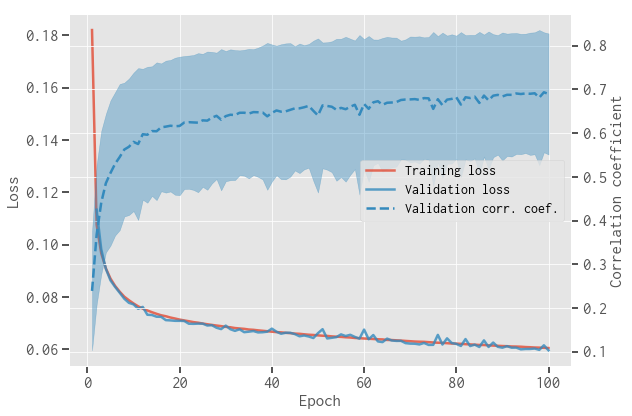

figure saved to file: /home/aly/git/cdae-eor/code/cdae-train-noft.pdf


In [111]:
fig, axes = plot_modelfit(modelfit2, figsize=(9, 6))
if True:
    fn = 'cdae-train-noft.pdf'
    fig.savefig(fn)
    print('figure saved to file: %s' % path.abspath(fn))

In [ ]:
model2 = modelfit2.model
model2_arch = model2.to_json()
weights2 = model2.get_weights()

now = datetime.now().strftime('%Y%m%dT%H%M')
modelfile = f'cdae.noft.{now}.hdf5'
model2.save(modelfile)
print(f'Saved model to file: {path.abspath(modelfile)}')